# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

Импортируем основные модули

In [1]:
import pandas as pd
import numpy as np
import time

from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import OrdinalEncoder
from sklearn import preprocessing


Импортируем дополнительные модули 

In [2]:

from tqdm.notebook import tqdm #Некоторые ячейки выполняются довольно долго, так что добавим полосу прогресса

Импортируем модели, не являющиеся бустингом

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

Импортируем бустинги

In [4]:
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

Загружаем данные

In [5]:
try:
    df = pd.read_csv('/datasets/autos.csv')
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')

Смотрим info

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

<b>Признаки</b>
 - DateCrawled — дата скачивания анкеты из базы
 - VehicleType — тип автомобильного кузова
 - RegistrationYear — год регистрации автомобиля
 - Gearbox — тип коробки передач
 - Power — мощность (л. с.)
 - Model — модель автомобиля
 - Kilometer — пробег (км)
 - RegistrationMonth — месяц регистрации автомобиля
 - FuelType — тип топлива
 - Brand — марка автомобиля
 - Repaired — была машина в ремонте или нет
 - DateCreated — дата создания анкеты
 - NumberOfPictures — количество фотографий автомобиля
 - PostalCode — почтовый индекс владельца анкеты (пользователя)
 - LastSeen — дата последней активности пользователя
 
<b>Целевой признак</b>
 - Price — цена (евро)

<b>DateCrawled, LastSeen</b> и<b> DateCreated</b> имеет тип <i>object</i>. Это дата скачивания анкеты из базы, дата последней активности пользователя и дата создания анкеты. Очевидно, эти признаки не влияют на потенциальную стоимость автомобиля или же влияют незначительно. Так же не влияет <b>PostalCode</b>. Их можно удалить.

In [7]:
df.drop(columns = ['DateCrawled', 'DateCreated', 'LastSeen', 'PostalCode'], inplace=True)


In [8]:
df['NumberOfPictures'].sum()

0

Мы видим, что <b>NumberOfPictures</b> имеет ноль во всех строчках, т.к. суммарное количество ноль, так что тоже убираем.

In [9]:
df.drop(columns = ['NumberOfPictures'], inplace=True)
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              354369 non-null  int64 
 1   VehicleType        316879 non-null  object
 2   RegistrationYear   354369 non-null  int64 
 3   Gearbox            334536 non-null  object
 4   Power              354369 non-null  int64 
 5   Model              334664 non-null  object
 6   Kilometer          354369 non-null  int64 
 7   RegistrationMonth  354369 non-null  int64 
 8   FuelType           321474 non-null  object
 9   Brand              354369 non-null  object
 10  Repaired           283215 non-null  object
dtypes: int64(5), object(6)
memory usage: 29.7+ MB


Проверка на дубликаты

In [10]:
df.duplicated().sum()

27543

Удаляем явные дубликаты

In [11]:
df.drop_duplicates(inplace=True)

Смотрим пропуски

In [12]:
df.isna().sum()

Price                    0
VehicleType          35249
RegistrationYear         0
Gearbox              17578
Power                    0
Model                18532
Kilometer                0
RegistrationMonth        0
FuelType             31122
Brand                    0
Repaired             66427
dtype: int64

Мы можем видеть, что пропуски только в категориальных переменных. Запишем их как <i>unknown</i>. Для начала выделим категориальные переменные и затем заполним пропуски.

In [13]:
cat_columns = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']
df[cat_columns] = df[cat_columns].fillna('unknown')
df.isna().sum()

Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
Repaired             0
dtype: int64

### Работа с выбросами
Рассмотрим количественные признаки

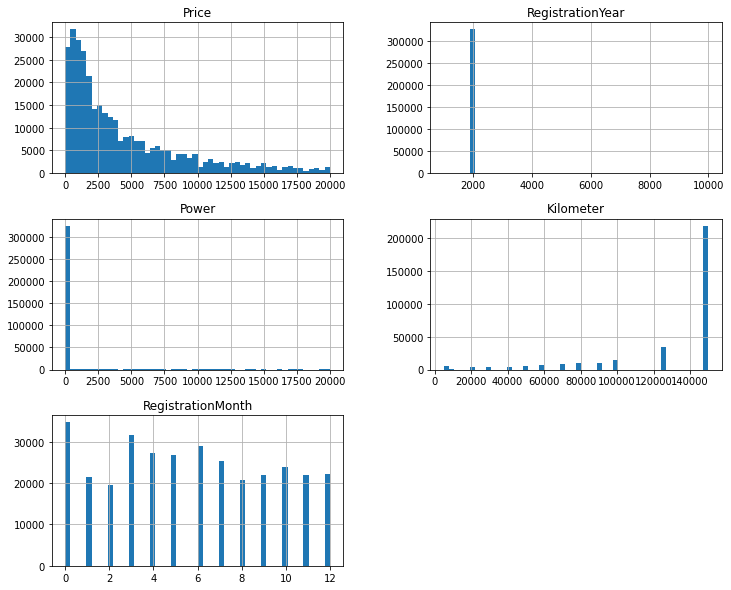

In [14]:
numeric = ['Price', 'RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth']
df[numeric].hist(bins = 50, figsize = (12, 10));

Мы видим проблемы в переменных Power и Price. В переменной Price есть автомобили с нулевой и близкой стоимости, в переменной Power есть очень большие и очень маленькие значения. 

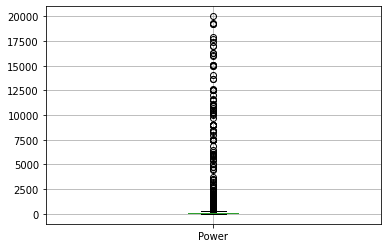

In [15]:
df.boxplot(column = 'Power');

In [16]:
df['Power'].describe()

count    326826.000000
mean        110.244705
std         195.886373
min           0.000000
25%          69.000000
50%         105.000000
75%         141.000000
max       20000.000000
Name: Power, dtype: float64

Малое количество автомобилей имеют мощность меньше 50 л.с., максимальное значение в районе 2500. Заменим выбивающиеся значения медианой.

count    326826.000000
mean        120.444799
std          62.442105
min          50.000000
25%          88.000000
50%         105.000000
75%         141.000000
max        2461.000000
Name: Power, dtype: float64

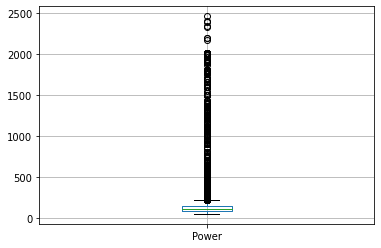

In [17]:
df.loc[ (df['Power'] < 50)|(df['Power'] > 2500), 'Power'] = df['Power'].median()
df.boxplot(column = 'Power');
df['Power'].describe()

<font color='blue'><b>Комментарий ревьюера 2: </b></font> ✔️\
<font color='green'>👍</font>

Цена - целевой признак. Мы не можем делать замену, потому придётся удалить нереалистичные значения.

In [18]:
df['Price'].describe(), len(df)

(count    326826.000000
 mean       4403.747330
 std        4518.209808
 min           0.000000
 25%        1000.000000
 50%        2700.000000
 75%        6350.000000
 max       20000.000000
 Name: Price, dtype: float64,
 326826)

In [19]:
df = df.query('Price >= 500')
df['Price'].describe(), len(df)

(count    293333.000000
 mean       4883.967672
 std        4526.767511
 min         500.000000
 25%        1490.000000
 50%        3200.000000
 75%        6950.000000
 max       20000.000000
 Name: Price, dtype: float64,
 293333)

Проверяем на всякий случай год

In [20]:
df['RegistrationYear'].describe()

count    293333.000000
mean       2004.167012
std          67.295587
min        1000.000000
25%        1999.000000
50%        2004.000000
75%        2008.000000
max        9999.000000
Name: RegistrationYear, dtype: float64

Здесь также есть нереалистичные значения. Скорее всего эта переменная не так важна, мы можем заменить на значени 2004 те, что выбиваются за рамки.

In [21]:
df.loc[ (df['RegistrationYear'] < 1980)|(df['RegistrationYear'] > 2020), 'RegistrationYear'] = 2004
df['RegistrationYear'].describe()

count    293333.00000
mean       2003.79059
std           6.42583
min        1980.00000
25%        2000.00000
50%        2004.00000
75%        2008.00000
max        2019.00000
Name: RegistrationYear, dtype: float64

### Кодируем категориальные переменные

In [22]:
df_enc = df.copy()
enc_all, enc_valid, enc_test = np.split(df_enc.sample(frac=1, random_state=42),
                       [int(.6*len(df)), int(.8*len(df))])

print(len(enc_valid))

58667


In [23]:
enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
enc.fit(enc_all[cat_columns])

enc_all[cat_columns] = enc.transform(enc_all[cat_columns])
enc_valid[cat_columns] = enc.transform(enc_valid[cat_columns])
enc_test[cat_columns] = enc.transform(enc_test[cat_columns])

enc_all.head(2)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
42970,11990,0.0,2009,1.0,241.0,249.0,125000,4,6.0,24.0,0.0
108774,4850,4.0,2001,1.0,192.0,11.0,150000,9,6.0,2.0,0.0


Разбиваем датасект на обучующую и тестовую выборки # На фичи и таргеты.

In [24]:
X = df_enc.drop(columns=['Price'])
y = df_enc.Price

X_train = enc_all.drop(columns=['Price'])
y_train = enc_all.Price

X_valid = enc_valid.drop(columns=['Price'])
y_valid = enc_valid.Price

X_test = enc_test.drop(columns=['Price'])
y_test = enc_test.Price

print(len(X_train),len(X_valid),len(X_test))
print(len(y_train),len(y_valid),len(y_test))


175999 58667 58667
175999 58667 58667


Нормализуем выборку

In [25]:
numeric = ['RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth']
scaler = StandardScaler()
scaler.fit(X_train[numeric])
X_train[numeric] = scaler.transform(X_train[numeric])
X_valid[numeric] = scaler.transform(X_valid[numeric])
X_test[numeric] = scaler.transform(X_test[numeric])

## Обучение моделей

### Модели, не являющиеся бустингом

Сначала проверим модели, которые НЕ являются градиентным бустингом

#### Linear Regressian

In [26]:
df_lin = df.copy()

df_lin = pd.get_dummies(df_lin, drop_first=True)
df_lin.head(2)

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,...,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,Repaired_unknown,Repaired_yes
1,18300,2011,190.0,125000,5,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,9800,2004,163.0,125000,8,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [27]:
Xlin = df_lin.drop(columns=['Price'])
ylin = df_lin.Price
Xlin_train, Xlin_valid, Xlin_test = \
              np.split(Xlin.sample(frac=1, random_state=42),
                       [int(.6*len(df)), int(.8*len(df))])
print(len(Xlin_train),len(Xlin_valid),len(Xlin_test))

ylin_train, ylin_valid, ylin_test = \
              np.split(ylin.sample(frac=1, random_state=42),
                       [int(.6*len(df)), int(.8*len(df))])
print(len(ylin_train),len(ylin_valid),len(ylin_test))

175999 58667 58667
175999 58667 58667


In [28]:
numeric = ['RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth']
scaler = StandardScaler()
scaler.fit(Xlin_train[numeric])
Xlin_train[numeric] = scaler.transform(Xlin_train[numeric])
Xlin_valid[numeric] = scaler.transform(Xlin_valid[numeric])
Xlin_test[numeric] = scaler.transform(Xlin_test[numeric])

In [29]:
%%time


linear = LinearRegression()

now = time.time()
linear.fit(Xlin_train, ylin_train)
linear_train_time = time.time() - now

now = time.time()
pred = linear.predict(Xlin_valid)
linear_pred_time = time.time() - now

rmse_linear = mse(ylin_valid, pred)**0.5
rmse_linear

CPU times: user 12.1 s, sys: 4.31 s, total: 16.5 s
Wall time: 16.5 s


2620.256115988209

#### DecisionTreeRegressor

In [30]:
%%time


rmse_tree = 0
tree = None
for depth in tqdm(range(5, 16 ,5)):
    for leaf in tqdm(range(5, 11, 5)):
        model = DecisionTreeRegressor(max_depth=depth, min_samples_leaf = leaf, random_state=42)
        
        now = time.time() #Запоминаем время начала обучения
        model.fit(X_train, y_train)
        model_train_time = time.time() - now #Записываем время обучения модели в отдельную переменную
        
        now = time.time() #Запоминаем время начала предсказания
        pred = model.predict(X_valid)
        model_pred_time = time.time() - now #Записываем время предсказания модели в отдельную переменную
        
        rmse = mse(y_valid, pred)**0.5
        
        if rmse <= rmse_tree or rmse_tree == 0: #Подбираем лучшую модель: если RMSE < RMSE первой модели, то запоминаем
            tree = model
            rmse_tree = rmse
            tree_train_time = model_train_time #Записываем в переменную время для ЛУЧШЕЙ модели
            tree_pred_time = model_pred_time #Записываем в переменную время для ЛУЧШЕЙ модели
            
print(tree, rmse_tree)



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

DecisionTreeRegressor(max_depth=15, min_samples_leaf=10, random_state=42) 1964.0230615523215
CPU times: user 2.21 s, sys: 101 ms, total: 2.32 s
Wall time: 2.49 s


#### RandomForestRegressor

In [31]:
%%time


rmse_forest = 0
forest = None

for depth in tqdm(range(10,16,5)):
    for est in tqdm(range(10,16,5)):
        model = RandomForestRegressor(max_depth=depth, n_estimators=est, random_state=42)
        
        now = time.time() #Запоминаем время начала обучения
        model.fit(X_train, y_train)
        model_train_time = time.time() - now #Записываем время обучения модели в отдельную переменную
        
        now = time.time() #Запоминаем время начала предсказания
        pred = model.predict(X_valid)
        model_pred_time = time.time() - now #Записываем время предсказания в отдельную переменную
        
        rmse = mse(y_valid, pred)**0.5
        
        if rmse <= rmse_forest or rmse_forest == 0: #Подбираем лучшую модель: если RMSE < RMSE первой модели, то запоминаем
            forest = model
            rmse_forest = rmse
            forest_train_time = model_train_time #Записываем в переменную время для ЛУЧШЕЙ модели
            forest_pred_time = model_pred_time #Записываем в переменную время для ЛУЧШЕЙ модели
            
print(forest, rmse_forest)


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

RandomForestRegressor(max_depth=15, n_estimators=15, random_state=42) 1796.5562779995953
CPU times: user 15.3 s, sys: 147 ms, total: 15.4 s
Wall time: 15.5 s


### Бустинги

Мы будем использовать LGBMRegressor и CatBoost. Эти два бустинга работают с категориальными переменными, потому нам не нужно кодировать категориальные признаки, так что разобьём выборку заново.

In [32]:
df_cat = df.copy()

df_cat['VehicleType'] = df_cat['VehicleType'].astype('category')
df_cat['Gearbox'] = df_cat['Gearbox'].astype('category')
df_cat['Model'] = df_cat['Model'].astype('category')
df_cat['FuelType'] = df_cat['FuelType'].astype('category')
df_cat['Brand'] = df_cat['Brand'].astype('category')
df_cat['Repaired'] = df_cat['Repaired'].astype('category')


Xcat = df_cat.drop(columns=['Price'])
ycat = df_cat.Price
Xcat_train, Xcat_valid, Xcat_test = \
              np.split(Xcat.sample(frac=1, random_state=42),
                       [int(.6*len(df)), int(.8*len(df))])
print(len(Xcat_train),len(Xcat_valid),len(Xcat_test))

ycat_train, ycat_valid, ycat_test = \
              np.split(ycat.sample(frac=1, random_state=42),
                       [int(.6*len(df)), int(.8*len(df))])
print(len(ycat_train),len(ycat_valid),len(ycat_test))

df_cat.info()

175999 58667 58667
175999 58667 58667
<class 'pandas.core.frame.DataFrame'>
Int64Index: 293333 entries, 1 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   Price              293333 non-null  int64   
 1   VehicleType        293333 non-null  category
 2   RegistrationYear   293333 non-null  int64   
 3   Gearbox            293333 non-null  category
 4   Power              293333 non-null  float64 
 5   Model              293333 non-null  category
 6   Kilometer          293333 non-null  int64   
 7   RegistrationMonth  293333 non-null  int64   
 8   FuelType           293333 non-null  category
 9   Brand              293333 non-null  category
 10  Repaired           293333 non-null  category
dtypes: category(6), float64(1), int64(4)
memory usage: 15.4 MB


#### LGBMRegressor

In [33]:
%%time


rmse_LightGBM = 0
LightGBM = None


for depth in tqdm(range(39,45,5)):
    for est in tqdm(range(44,45,1)):
        model = LGBMRegressor(boosting_type='gbdt',learning_rate=0.17, max_depth=depth, 
                              n_estimators=est, random_state=42)
        
        now = time.time()
        model.fit(X_train, y_train)
        model_train_time = time.time() - now
        
        now = time.time()
        pred = model.predict(X_valid)
        model_pred_time = time.time() - now
         
        rmse = mse(y_valid, pred)**0.5
        
        if rmse <= rmse_LightGBM or rmse_LightGBM == 0:
            LightGBM = model
            rmse_LightGBM = rmse
            LightGBM_train_time = model_train_time
            LightGBM_pred_time = model_pred_time
            
print(LightGBM, rmse_LightGBM)


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

LGBMRegressor(learning_rate=0.17, max_depth=44, n_estimators=44,
              random_state=42) 1836.3657030173745
CPU times: user 4.88 s, sys: 0 ns, total: 4.88 s
Wall time: 4.92 s


#### CatBoost

In [34]:
%%time


rmse_CatBoost = 0
CatBoost = None


for depth in tqdm(range(1,16,5)):
    for iterations in tqdm(range(34,45,5)):
        model = CatBoostRegressor(learning_rate=0.17, iterations=iterations, depth=depth, #cat_features = cat_columns,
                                   silent=True, random_state=42)
        
        now = time.time()
        model.fit(X_train, y_train) #cat_features = cat_columns)
        model_train_time = time.time() - now
        
        now = time.time()
        pred = model.predict(X_valid)
        model_pred_time = time.time() - now
         
        rmse = mse(y_valid, pred)**0.5
        
        if rmse <= rmse_CatBoost or rmse_CatBoost == 0:
            CatBoost = model
            rmse_CatBoost = rmse
            CatBoost_train_time = model_train_time
            CatBoost_pred_time = model_pred_time
            
print(CatBoost, rmse_CatBoost)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

<catboost.core.CatBoostRegressor object at 0x7f20f55e8070> 1818.8314683973394
CPU times: user 12.4 s, sys: 148 ms, total: 12.6 s
Wall time: 22.2 s


## Анализ моделей

По задаче необходимо выбрать лучшую модель с учётом скорости, кроме того RMSE на тестовой выборке должно быть меньше 2500.
Будем учитывать именно время обучения и предсказания модели с заданными параметрами, так как поиск лучших параметров может занять неограниченное время.

In [35]:
models = []
models.append([rmse_linear, linear_train_time, linear_pred_time])
models.append([rmse_tree, tree_train_time, tree_pred_time])
models.append([rmse_forest, forest_train_time, forest_pred_time])
models.append([rmse_LightGBM, LightGBM_train_time, LightGBM_pred_time])
models.append([rmse_CatBoost, CatBoost_train_time, CatBoost_pred_time])

final = pd.DataFrame(data=models, index=['Linear Regression', 'DecisionTreeRegressor', 'RandomForestRegressor',
                                         'LGBMRegressor','CatBoost'], 
                     columns=['RMSE на валидационной выборке', 'Время обучения', 'Время предсказания'])
final

,RMSE на валидационной выборке,Время обучения,Время предсказания
Linear Regression,2620.256116,16.282280,0.197655
DecisionTreeRegressor,1964.023062,0.478157,0.011650
RandomForestRegressor,1796.556278,5.298105,0.162925
LGBMRegressor,1836.365703,2.079430,0.208637
CatBoost,1818.831468,3.392958,0.013955


Мы видим, что время предсказаний для каждой модели небольшое, измеряемое в десятых и сотых долях секунды, так что важнее время обучения. 
Наименьшее время обучения у линейной регрессии, однако её показатель  RMSE слишком большой. Лучший результат RMSE у случайного леса, однако у LGBMRegressor близкий к нему результат и меньше время обучения.

Лучшими моделями будут RandomForestRegressor и LGBMRegressor. У бустинга немного ниже время обучения, у леса - лучше показатели. Проверим эти модели на тестовой выборке.

<b>Для LGBMRegressor</b>

In [36]:
%%time

pred = LightGBM.predict(X_test)
rmse = mse(y_test, pred)**0.5
rmse

CPU times: user 223 ms, sys: 0 ns, total: 223 ms
Wall time: 207 ms


1806.618867146949

<b>Для случайного леса</b>

In [37]:
%%time

pred = forest.predict(X_test)
rmse = mse(y_test, pred)**0.5
rmse

CPU times: user 176 ms, sys: 145 µs, total: 176 ms
Wall time: 211 ms


1759.6859906879629

Как видим, разница RMSE почти незначительна, но бустинг быстрее.

На тестовой выборке модель LGBMRegressor показала себя даже лучше, чем на валидационной.

## Вывод

Мы протестировали несколько моделей, измеряя скорость их работы и точность предсказаний.

На этапе предобработки данных мы избавились от дубликатов и пропусков, а также избавились от выбросов в числовых переменных, убрав нереалистичные значения.

Мы использовали <b>Ordinar Encoder</b>, поскольку он не создаёт новые столбцы и благодаря нему модели работают быстрее. Этот вид кодировки данных подходит для моделей основанных на деревьях.

<b>Результаты тестирования</b>
По условию проекта, нужно было проверить не только бустинги, но и обычные модели.

Линейная регрессия показала себя плохо что может свидетельствовать о нелинейности зависимости данных. Однако, в данном случае, Лес Решений показал себя немного хуже модели бустинга LGBMRegressor.



В результате мы научились: использовать модели бустинга, замерять и учитывать время их выполнения, использовать адекватные для конкретных ситуаций методы кодирования категориальных данных.

Была выполнена задача добиться RMSE <= 2500.